In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

/Users/gabrielcha/miniforge3/envs/cb-llm/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/gabrielcha/miniforge3/envs/cb-llm/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <063DD42B-A1DA-3BBE-AD5E-03C12F7E3DBA> /Users/gabrielcha/miniforge3/envs/cb-llm/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/gabrielcha/miniforge3/envs/cb-llm/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/gabrielcha/miniforge3/envs/cb-llm/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/gabrielcha/miniforge3/envs/cb-llm/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/gabrielcha/miniforge3/envs/cb-llm/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this

Using device: cpu
Train Epoch: 1 [0/60000 (0%)]	Total Loss: 10.577299
Train Epoch: 1 [6400/60000 (11%)]	Total Loss: 6.754613
Train Epoch: 1 [12800/60000 (21%)]	Total Loss: 6.201109
Train Epoch: 1 [19200/60000 (32%)]	Total Loss: 5.281593
Train Epoch: 1 [25600/60000 (43%)]	Total Loss: 5.471844
Train Epoch: 1 [32000/60000 (53%)]	Total Loss: 5.368845
Train Epoch: 1 [38400/60000 (64%)]	Total Loss: 4.488894
Train Epoch: 1 [44800/60000 (75%)]	Total Loss: 4.703748
Train Epoch: 1 [51200/60000 (85%)]	Total Loss: 4.855730
Train Epoch: 1 [57600/60000 (96%)]	Total Loss: 3.998980

Test set: Average loss: 3.9488, Accuracy: 7734/10000 (77.34%), Concept Accuracy: 85.25%

Train Epoch: 2 [0/60000 (0%)]	Total Loss: 4.062124
Train Epoch: 2 [6400/60000 (11%)]	Total Loss: 4.387104
Train Epoch: 2 [12800/60000 (21%)]	Total Loss: 4.048105
Train Epoch: 2 [19200/60000 (32%)]	Total Loss: 3.944121
Train Epoch: 2 [25600/60000 (43%)]	Total Loss: 4.331257
Train Epoch: 2 [32000/60000 (53%)]	Total Loss: 4.454309
Train E

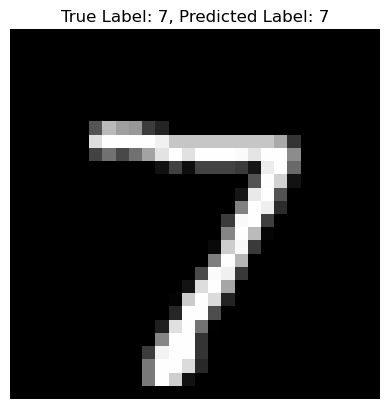

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# For visualization
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

class ConceptBottleneckCNN(nn.Module):
    def __init__(self, num_concepts):
        super(ConceptBottleneckCNN, self).__init__()
        # feature extraction layers
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        # concept bottleneck layer
        self.fc_concepts = nn.Linear(320, num_concepts)
        # classifier layer
        self.fc_classifier = nn.Linear(num_concepts, 10)
    
    def forward(self, x):
        # feature extraction
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.dropout(self.conv2(x)), 2))
        x = x.view(-1, 320)
        # predict concepts
        concepts = torch.sigmoid(self.fc_concepts(x))
        # predict class using concepts
        logits = self.fc_classifier(concepts)
        return concepts, logits

# Hyperparameters
batch_size = 64
test_batch_size = 1000
epochs = 5
learning_rate = 0.001

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load datasets
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# Initialize the model
num_concepts = 7  # Number of concepts
model = ConceptBottleneckCNN(num_concepts).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def generate_concept_labels(labels):
    has_loop = []
    num_strokes = []
    is_symmetric = []
    has_diagonal = []
    has_vertical = []
    has_horizontal = []
    is_circular = []
    for label in labels:
        digit = label.item()
        # has Loop
        has_loop.append(1.0 if digit in [0, 6, 8, 9] else 0.0)
        # number of Strokes (simplified estimation)
        if digit in [1]:
            num_strokes.append(1.0)
        elif digit in [2, 3, 5, 7]:
            num_strokes.append(2.0)
        else:
            num_strokes.append(3.0)
        # is symmetric
        is_symmetric.append(1.0 if digit in [0, 3, 8] else 0.0)
        # had diagonal line
        has_diagonal.append(1.0 if digit in [2, 4, 7] else 0.0)
        # had vertical line
        has_vertical.append(1.0 if digit in [1, 4] else 0.0)
        # has horizontal line
        has_horizontal.append(1.0 if digit in [5, 7] else 0.0)
        # is circular
        is_circular.append(1.0 if digit in [0, 6, 8, 9] else 0.0)
    # stack concepts into a tensor
    concept_labels = torch.tensor([
        has_loop,
        num_strokes,
        is_symmetric,
        has_diagonal,
        has_vertical,
        has_horizontal,
        is_circular
    ], dtype=torch.float).T
    return concept_labels

# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        concept_labels = generate_concept_labels(target).to(device)
        optimizer.zero_grad()
        concepts_pred, logits = model(data)
        # Concept losses
        binary_concept_indices = [0, 2, 3, 4, 5, 6]
        # Calculate binary concept losses
        concept_loss_binary = sum(
            bce_loss(concepts_pred[:, i], concept_labels[:, i]) for i in binary_concept_indices
        )
        # 'Num Strokes' is treated as regression (continuous variable)
        concept_loss_strokes = mse_loss(concepts_pred[:, 1], concept_labels[:, 1])
        # Total concept loss
        concept_loss = concept_loss_binary + concept_loss_strokes
        # Classification loss
        classification_loss = F.cross_entropy(logits, target)
        # Total loss
        total_loss = concept_loss + classification_loss
        total_loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTotal Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), total_loss.item()))

# Testing function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    concept_correct = 0
    total_concepts = 0
    bce_loss = nn.BCELoss(reduction='sum')
    mse_loss = nn.MSELoss(reduction='sum')
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            concept_labels = generate_concept_labels(target).to(device)
            concepts_pred, logits = model(data)
            # Losses
            binary_concept_indices = [0, 2, 3, 4, 5, 6]
            # Calculate binary concept losses
            concept_loss_binary = sum(
                bce_loss(concepts_pred[:, i], concept_labels[:, i]) for i in binary_concept_indices
            )
            # 'Num Strokes' loss
            concept_loss_strokes = mse_loss(concepts_pred[:, 1], concept_labels[:, 1])
            # Total concept loss
            concept_loss = concept_loss_binary + concept_loss_strokes
            classification_loss = F.cross_entropy(logits, target, reduction='sum')
            total_loss = concept_loss + classification_loss
            test_loss += total_loss.item()
            # Predictions
            pred = logits.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # Concept accuracy
            # For binary concepts
            concept_pred_labels = concepts_pred.clone()
            for i in binary_concept_indices:
                concept_pred_labels[:, i] = (concepts_pred[:, i] > 0.5).float()
            # For 'Num Strokes' concept
            concept_pred_labels[:, 1] = torch.round(concepts_pred[:, 1])
            concept_correct += concept_pred_labels.eq(concept_labels).sum().item()
            total_concepts += concept_labels.numel()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    concept_accuracy = 100. * concept_correct / total_concepts
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%), Concept Accuracy: {:.2f}%\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy, concept_accuracy))

# Training loop
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

# Visualize and interpret concepts for a single image
index = 0  # Change index to test different images
image, label = test_dataset[index]
image_tensor = image.unsqueeze(0).to(device)
concept_labels = generate_concept_labels(torch.tensor([label]))
print(f'True Label: {label}')
print(f'True Concepts: {concept_labels.numpy()}')

model.eval()
with torch.no_grad():
    concepts_pred, logits = model(image_tensor)
    predicted_label = logits.argmax(dim=1).item()
    concepts_pred = concepts_pred.cpu().numpy().squeeze()
    # Process predicted concepts
    concepts_pred_labels = concepts_pred.copy()
    binary_concept_indices = [0, 2, 3, 4, 5, 6]
    for i in binary_concept_indices:
        concepts_pred_labels[i] = int(concepts_pred[i] > 0.5)
    concepts_pred_labels[1] = round(concepts_pred[1])

print(f'Predicted Label: {predicted_label}')
print(f'Predicted Concepts: {concepts_pred_labels}')

# Interpret the concepts
concept_names = [
    'Has Loop', 'Num Strokes', 'Is Symmetric',
    'Has Diagonal', 'Has Vertical', 'Has Horizontal', 'Is Circular'
]
for name, true_val, pred_val in zip(concept_names, concept_labels.numpy().squeeze(), concepts_pred_labels):
    print(f'{name}: True - {int(true_val)}, Predicted - {int(pred_val)}')

# Visualize the image
image_np = image.numpy().squeeze()
plt.imshow(image_np, cmap='gray')
plt.title(f'True Label: {label}, Predicted Label: {predicted_label}')
plt.axis('off')
plt.show()


In [3]:
import numpy as np

# Store activations for concepts and contributions
activations = []
contributions = []

# Hook function to capture concept activations and contributions
def hook_fn(module, input, output):
    # Concept activations
    activations.append(output.detach().cpu().numpy())
    # Concept contributions (activations * classifier weights)
    contributions.append((output @ model.fc_classifier.weight.T).detach().cpu().numpy())

# Register the hook on the concept bottleneck layer
hook = model.fc_concepts.register_forward_hook(hook_fn)

# Perform inference on a batch of test images to capture activations and contributions
model.eval()
data, target = next(iter(test_loader))  # Get one batch of test data
data, target = data.to(device), target.to(device)
with torch.no_grad():
    _, logits = model(data)

# Convert activations and contributions to numpy arrays
activations = np.concatenate(activations, axis=0)
contributions = np.concatenate(contributions, axis=0)

# Remove the hook
hook.remove()


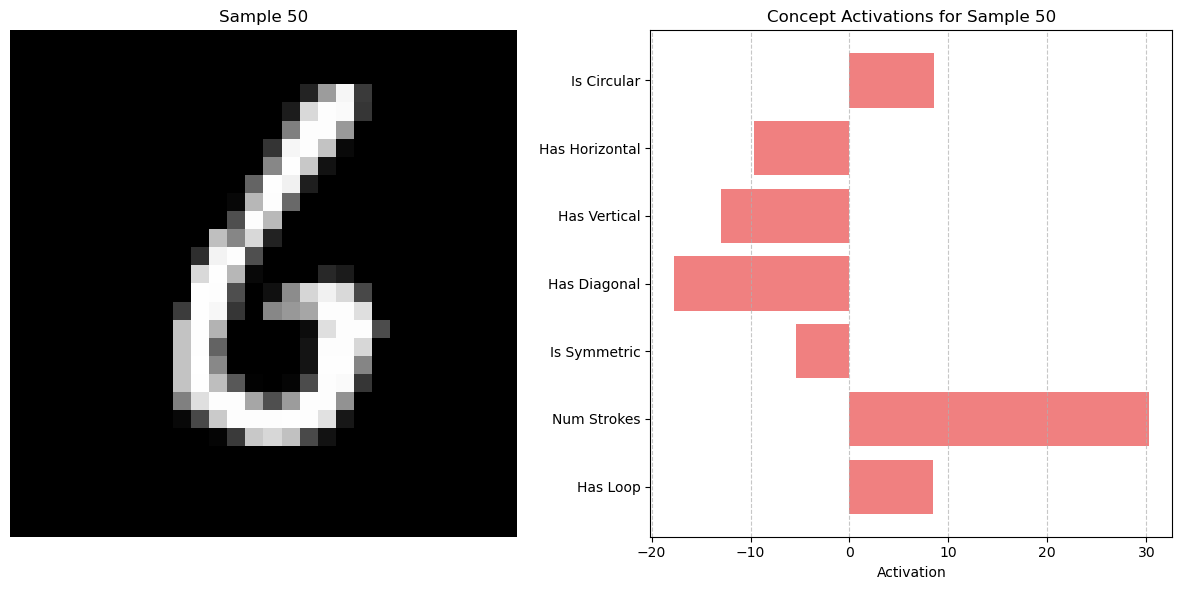

In [4]:
# Function to plot the sample image and its concept activations as a horizontal bar chart
def plot_sample_and_activations(data, activations, index, concept_names):
    # Select the image and activations for the specified sample index
    image_tensor = data[index].cpu()
    activations_for_sample = activations[index, :len(concept_names)]
    
    # Plot the image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    image_np = image_tensor.numpy().squeeze()
    plt.imshow(image_np, cmap='gray')
    plt.title(f'Sample {index}')
    plt.axis('off')
    
    # Plot concept activations as a horizontal bar chart
    plt.subplot(1, 2, 2)
    plt.barh(concept_names, activations_for_sample, color='lightcoral')
    plt.xlabel('Activation')
    plt.title(f'Concept Activations for Sample {index}')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Visualize the specified sample and its concept activations
sample_index = 50  # Change index to visualize a different sample
plot_sample_and_activations(data, activations, sample_index, concept_names)


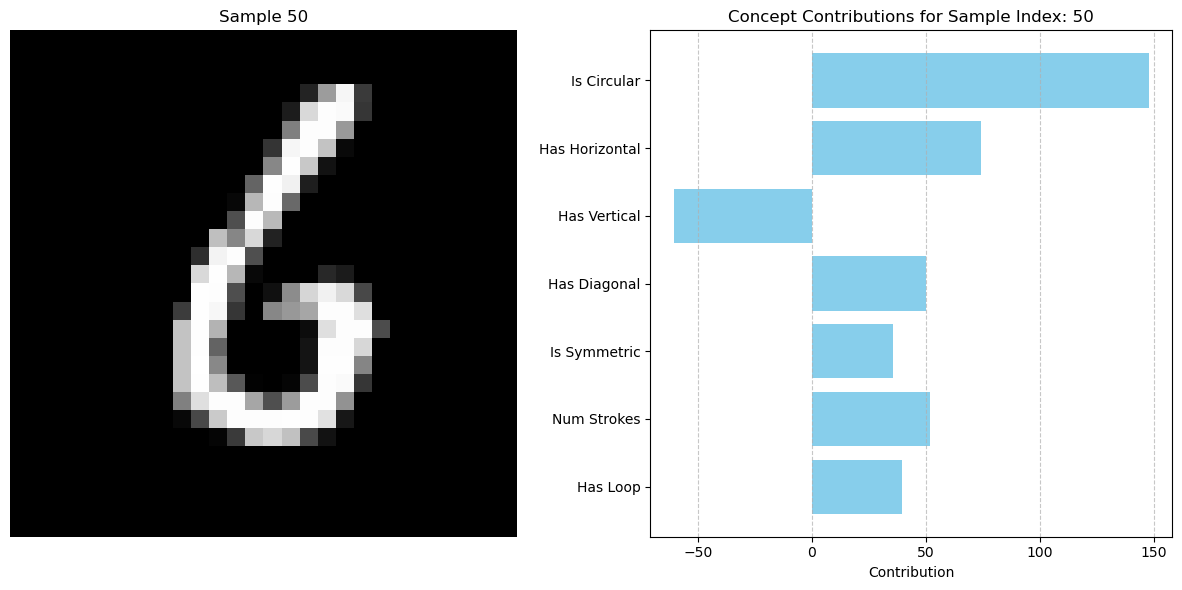

In [5]:
# Function to plot concept contributions and the sample image
def plot_sample_and_contributions(data, contributions, index, concept_names):
    # Select the image and contributions for the specified sample index
    image_tensor = data[index].cpu()
    contributions_for_sample = contributions[index, :len(concept_names)]
    
    # Plot the image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    image_np = image_tensor.numpy().squeeze()
    plt.imshow(image_np, cmap='gray')
    plt.title(f'Sample {index}')
    plt.axis('off')
    
    # Plot concept contributions as a horizontal bar chart
    plt.subplot(1, 2, 2)
    plt.barh(concept_names, contributions_for_sample, color='skyblue')
    plt.xlabel('Contribution')
    plt.title(f'Concept Contributions for Sample Index: {index}')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Visualize the specified sample and its concept contributions
sample_index = 50  # Change index to visualize a different sample
data, _ = next(iter(test_loader))  # Load a batch of test data
plot_sample_and_contributions(data, contributions, sample_index, concept_names)
